<a href="https://colab.research.google.com/github/mckang6113875/AP_Test_OPEN/blob/main/Image_Processing_edit1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **자율주차시험팀**

For Image Processing **Serminar**


# Canny edge detector
The **Canny edge detector**
5 step

1. Noise reduction;
2. Gradient calculation;
3. Non-Maximum suppression;
4. Double threshold;
5. Edge tracking by hysterisis;

In [37]:
! git clone https://github.com/mckang6113875/AP_Test_OPEN.git

fatal: destination path 'AP_Test_OPEN' already exists and is not an empty directory.


## 1. Noise Reduction
One way to get rid of the noise on the image, is by applying Gaussian blur to smooth it. To do so, image convolution technique is applied with a Gaussian Kernel (3x3, 5x5 etc). The kernel size depend on the expected blurring effect.
Basically, the smaller is the kernel, the less visible is the blur.
In our exmple, we will use a 5 by 5 Gausiaan kernel.

\begin{equation*}
G_{i,j} = \frac{1}{2 \pi \sigma^2}
exp \left(-\frac{(i-k)^2 + (j-k)^2}{2 \sigma^2}
\right) ; 0 \le i, j \le 2k
\end{equation*}


In [38]:
import numpy as np

def gaussian_kernel(size, sigma = 1):
  hsize = int(size) // 2
  x, y = np.mgrid[-hsize:hsize+1, -hsize:hsize+1]
  normal = 1 / (2.0 * np.pi * sigma**2)
  g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) * normal
  return g
  
print ("Define gaussin_kernel")

Define gaussin_kernel


In [39]:
g2 = gaussian_kernel(5,1.4)

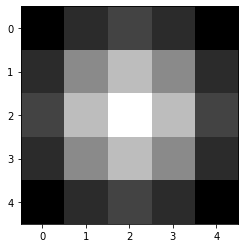

In [40]:
# for testing
from matplotlib import pyplot as plt
plt.imshow (g2, cmap = 'gray')


After applying the Gaussian blur, we get the following result:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  


Text(0.5, 0.01, '(a) Original Image, and (b) Blurred Image with a Gaussian filter (sigma=1.4, kernel size of 5x5)')

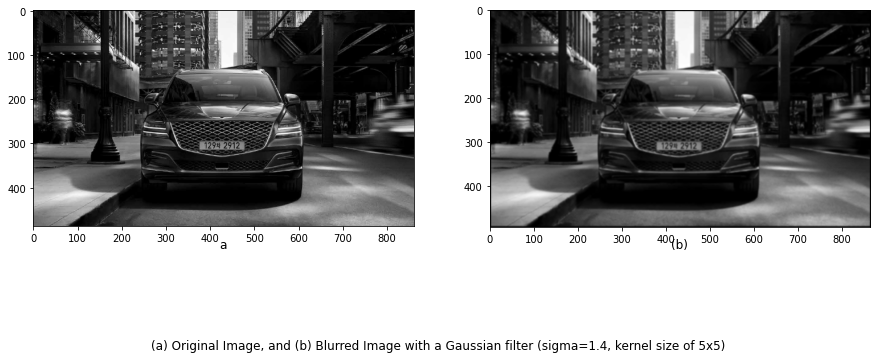

In [41]:
from skimage import io
from skimage import color
from scipy import signal
from matplotlib import pyplot as plt

originalImage = color.rgb2gray(io.imread('/content/AP_Test_OPEN/GV80.png'))
gKernel = gaussian_kernel(5,1.4)
blurImage = signal.convolve2d(originalImage, gKernel)

fig, axs = plt.subplots(1, 2, figsize=(15, 6.5))
axs[0].imshow(originalImage, cmap= 'gray')
axs[0].text(0.5,  -0.1, 'a', size=12, ha='center', transform=axs[0]. transAxes)
axs[1].imshow(blurImage, cmap='gray')
axs[1].text(0.5, -0.1, '(b)',size=12,ha='center', transform=axs[1]. transAxes)
txt = '(a) Original Image, and (b) Blurred Image with a Gaussian filter (sigma=1.4, kernel size of 5x5)'
plt.figtext(0.5, 0.01, txt, wrap=True, ha='center', fontsize=12)

## 2. Gradient Calculation

The Gradient calculation step detects the edge intensity and direction by calculation the gradient of the image using edge detection operators.

Edges coorespond

Edges correspond to a change of pixel's intensity.
To detect it, the easiest way is to apply filters that highlight this intensity change in both directions: horizontal (x) and vertical (y)

When the image is smmthed, the derivatives $I_x$ and$I_y$ w.r.t. $x$ and $y$ are calculated. It can be implemented by convolving $I$ with **SOVEL** Kernels $K_x$ and $K_y$, respectively:

\begin{equation*}
K_x = \left(\begin{array}{ccc}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 &1 \end{array} \right) ,
K_y = \left(\begin{array}{ccc}
1 & 2 & 1 \\
0 & 0 & 0 \\
-1 & -2 & -1 \end{array} \right)
\end{equation*}

Then, the magnitude $G$ and the slope $\theta$ of the gradient are calculated as follow:

\begin{equation*}
\left |G \right| = \sqrt{I_x^2 + I_y^2}, \\
\theta(x,y) = \arctan\left( \frac{I_y}{I_x}\right)
\end{equation*}

Below is how the sobel filters are applied to the image, and how to get both intensity and edge direction matrices:









In [42]:
from scipy import ndimage
## Multi-dimensional image processing
from matplotlib import gridspec
# Customizing Figure Layouts

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0 ,1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)

    G = np.hypot(Ix, Iy)
    G = G/G.max() * 255 # 0~255
    theta = np.arctan2(Iy, Ix)

    return (G, theta)

print('Definition of Sobel Filter')

Definition of Sobel Filter


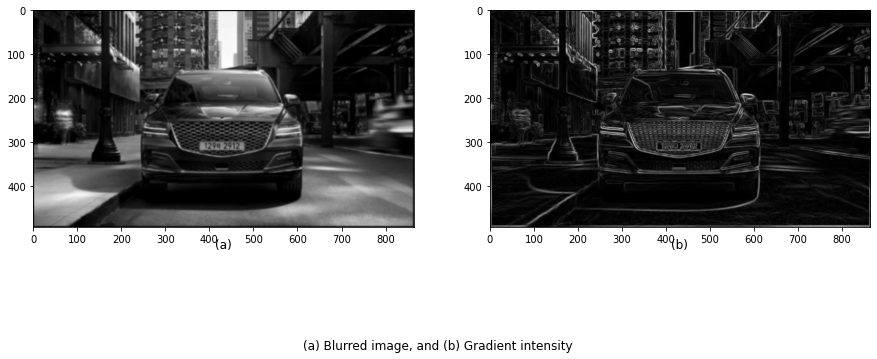

In [43]:
gradMag, gradDir = sobel_filters(blurImage)

fig, axs = plt.subplots(1, 2, figsize=(15, 6.5))
axs[0].imshow(blurImage, cmap='gray')
axs[0].text(0.5, -0.1, '(a)', size=12, ha='center', transform=axs[0].transAxes)
axs[1].imshow(gradMag, cmap='gray')
axs[1].text(0.5, -0.1, '(b)', size=12, ha='center', transform=axs[1].transAxes)
txt = '(a) Blurred image, and (b) Gradient intensity'
plt.figtext(0.5, 0.01, txt, wrap=True, ha='center', fontsize=12)
plt.show()

The results is almost the expected one, but we can see that some of the edge are thick and others are thin.
Non-Max Suppression step will help us mitigate the thick ones.
Moreover, the gradient intensity level is between 0 and 255 which is not uniform. The edges on the final results should have the same intensity (i-e. white pixel = 255).

## 3. Non-Maxinum Suppression

Idealy, the final image should have thin edges. 
Thus, we must perform non-maximum suppression to thin out the edges.

The principle is simple: thd algorithm goes through all the point on the gradient intensity matrix and finds the pixels with the maximum value in the edge direction.

Let's take two examples:

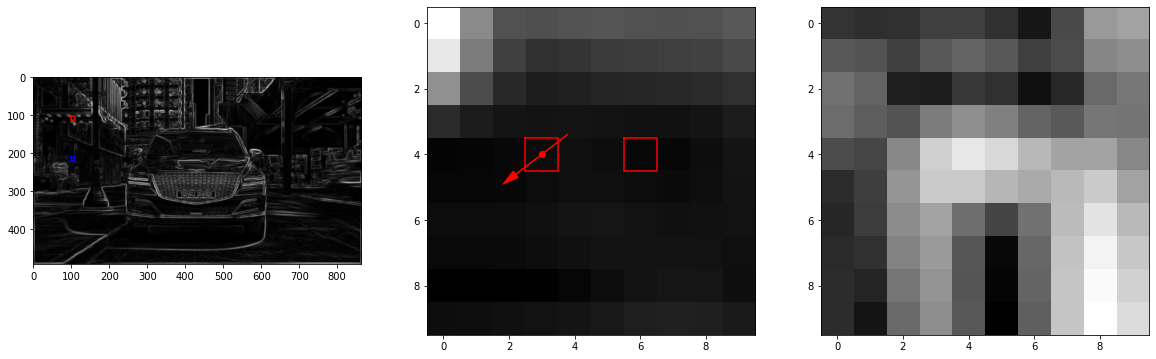

In [44]:
# for testing
# two sampe cases for easy understanding
sPt = [102, 100, 210, 100] # y1,x1, y2, x2
sSize = 10
f1 = gradMag[sPt[0]:sPt[0]+sSize, sPt[1]:sPt[1]+sSize]
th1 = gradDir[sPt[0]:sPt[0]+sSize, sPt[1]:sPt[1]+sSize]
f2 = gradMag[sPt[2]:sPt[2]+sSize, sPt[3]:sPt[3]+sSize]
th2 = gradDir[sPt[2]:sPt[2]+sSize, sPt[3]:sPt[3]+sSize]

def drawBox(ax, xp, yp, size, color):
    ax.plot([xp, xp+size, xp+size, xp, xp], [yp, yp, yp+size, yp+size, yp], color=color)

def drawArrow(ax, xp, yp, length, theta, color):
    hl = length /2 #half length of arrow
    dx = np.cos(theta)
    dy = -np.sin(theta) #Minus due to the reverse y-axis
    ax.scatter([xp], [yp], color=color)
    ax.arrow(xp-hl*dx, yp-hl*dy, length*dx, length*dy, head_width=0.25, head_length=0.5, color=color)

fig, axs = plt.subplots(1,3,figsize=(20, 6.5))
axs[0].imshow(gradMag, cmap='gray')
drawBox(axs[0], sPt[1], sPt[0], sSize, 'red')
drawBox(axs[0], sPt[3], sPt[2], sSize, 'blue')

axs[1].imshow(f1, cmap= 'gray')
pts = [3,4,6,4] # x1, y1, x2, y2
drawBox(axs[1], pts[0]-0.5, pts[1]-0.5,1, 'red')
drawArrow(axs[1], pts[0], pts[1], 2, th1[pts[1], pts[0]], 'red')
drawBox(axs[1], pts[2]-0.5, pts[3]-0.5, 1, 'red')

axs[2].imshow(f2, cmap='gray')
plt.show()

check if the pixel in the same direction has a higher intensity than the pixel that is currently processed;
Return the image processed with the non-max suppression algoritm.



*   Create a matrix initialized to 0 of the same size of the original gradient intensity matrix;
*   Identify the edge direction based on the angle value from the angle matrox;
*   Check if the pixel in the same direction has a higher intensity than the pixel that is currently processed;
*   Return the image processed with the non-max suppression algorothm.





In [45]:
def non_max_suppression (img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D*180./np.pi
    angle[angle <0] +=180

    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                q = 255
                r = 255

                # angle = 0
                if (0 <= angle [i, j] < 22.5) or (157.5 <= angle [i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                # angle = 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img [i+1, j-1]
                    r = img [i-1, j+1]
                # angle 90
                elif (67.5 <= angle [i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                # angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img [i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass

    return Z

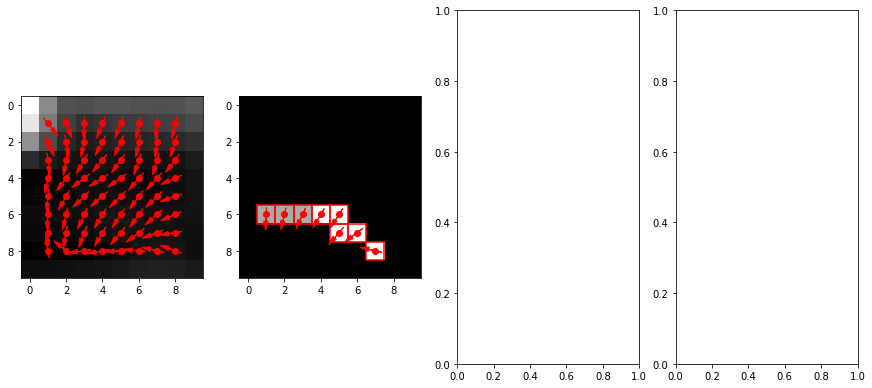

In [46]:
Z1 = non_max_suppression(f1, th1)
# apply non_max suppression to obtain Z2 for (f2, th2)

fig, axs = plt.subplots (1, 4, figsize=(15, 6.5))

axs[0].imshow(f1, cmap='gray')
for y in range(1, f1.shape[0]-1):
    for x in range(1, f1.shape[1]-1):
        drawArrow(axs[0], x,y,0.75, th1[y,x], 'red')

axs[1].imshow(Z1, cmap='gray')
for y in range(1, f1.shape[0]-1):
    for x in range(1, f1.shape[1]-1):
        if Z1[y,x] ==0: continue
        drawBox(axs[1], x-0.5, y-0.5, 1, 'red')
        drawArrow(axs[1], x, y, 0.75, th1[y,x], 'red')

plt.show()

The result is the same image with thinner edges. We can however still notice some variation regarding the edge's intensity:
some pixels seem to be brighter than others, and we will try to cover this shortcoming with the two final steps.

<function matplotlib.pyplot.show>

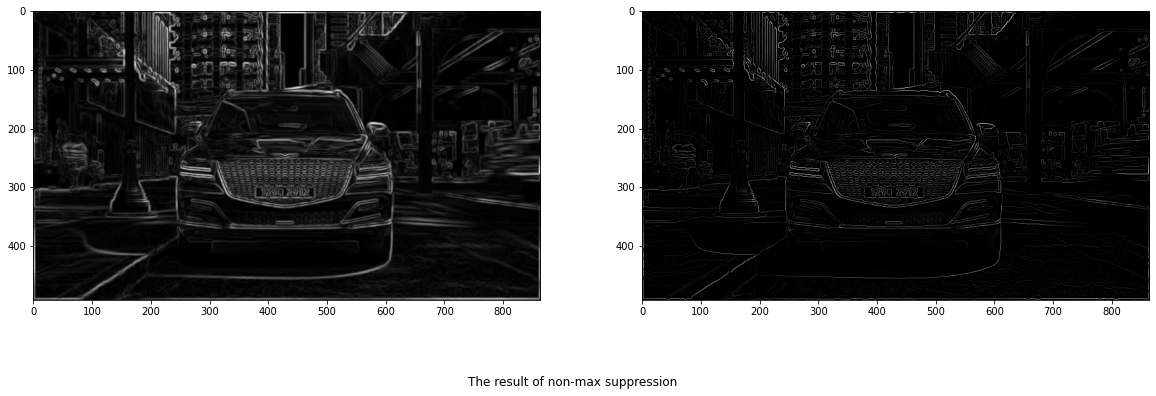

In [47]:
Z = non_max_suppression(gradMag, gradDir)

fig, axs = plt.subplots(1,2, figsize = (20, 6.5))
axs[0].imshow(gradMag, cmap='gray')
axs[1].imshow(Z,cmap='gray')
txt= 'The result of non-max suppression'
plt.figtext(0.5, 0.01, txt, wrap=True, ha='center', fontsize=12)
plt.show

## 4. Double Threshold

The double threshold step aims at identifying three kinds of pixels: **strong**, **weak**, and **non-relevant**:


1.   **Strong Pixels** are pixels that have an identity so high that we are sure they contribute to the final edge.
2.   **Weak pixels** are pixels that have an intensity value that is not enough to be considerd as strong ones, but yet not small enough to be considered as non-relevant for the edge detection
3.   Other pixels are considered as **non-relevant for the edge**.

Now you can see what the double thresholds holds for:


1.   **High threshold** is used to identify the strong pixels (Intensity higher than the high threshold)
2.   **Low threshold** is used to identify the non-relevant pixels (intensity lower than the low threshold)
3.   All pixels having intensity between both thresholds are flagged as weak and the Hysteresis mechanism (next step) will help us identify the ones that could be considered as strong and the ones that are considered as non-relevant.







In [48]:
def threshold (img, lowThresholdRatio=0.05, highThredholdRatio=0.09):
    highThreshold = img.max() * highThredholdRatio
    lowThreshold = highThreshold * lowThresholdRatio

    M,N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(127)
    strong = np.int32(255)

    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where ((img < highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return (res, weak, strong)
print ('Definition of Double threshold')

Definition of Double threshold


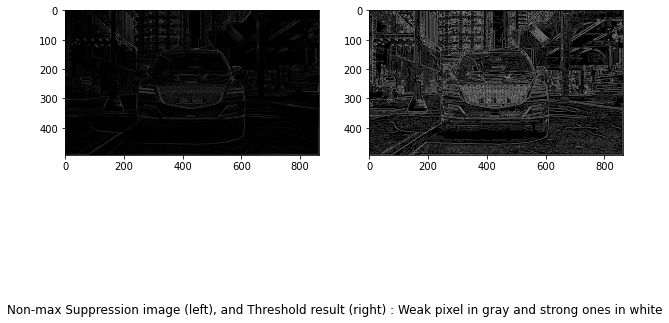

In [49]:
Zthresh, weak, strong = threshold (Z, 0.05, 0.09)

fig, axs = plt.subplots(1,2, figsize=(10, 6.5))
axs[0].imshow(Z, cmap='gray')
axs[1].imshow(Zthresh, cmap='gray')
txt='Non-max Suppression image (left), and Threshold result (right) : Weak pixel in gray and strong ones in white'
plt.figtext(0.5, 0.01, txt, wrap=True, ha='center', fontsize=12)
plt.show()


## 5. Edge Tracking by Hysteresis

Base on the threshold results, the hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed in a strong one, as described below:


In [57]:
d = np.array ([[1, 1, 1, 0, 0, -1, -1, -1], [1, 0, -1, 1, -1, 1, 0, -1]])

def trackEdge(img, i, j, weak=127, strong=255):
    img[i,j] = strong
    idxs =np.array([[i], [j]]) + d
    for p,q in zip(idxs[0], idxs[1]):
        try:
            if img[p,q] == weak:
                trackEdge(img, p, q)
        except IndexError:
            pass


def hysteresis (img, weak, strong = 255):
    strongIdx = np.where(img == strong)

    for i, j in zip(strongIdx[0], strongIdx[1]):
        idxs = np.array([[i], [j]]) + d
        for p, q in zip(idxs[0], idxs[1]):
            try:
                if img [p,q] == weak:
                    trackEdge(img, p, q)
            except IndexError: 
                pass

    weakIdx = np.where(img == weak)
    for i,j in zip(weakIdx[0], weakIdx[1]):
        img[i,j] = 0

    return img

print ('Definition of Hysteresis')


Definition of Hysteresis


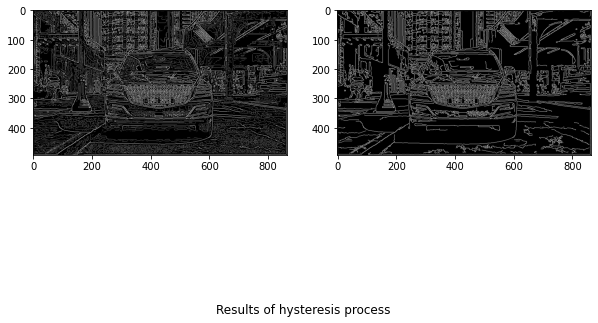

In [59]:
finalImg = Zthresh.copy()
finalImg = hysteresis (finalImg, weak)

fig, axs = plt.subplots(1,2, figsize=(10, 6.5))
axs[0].imshow(Zthresh, cmap='gray')
axs[1].imshow(finalImg, cmap='gray')
txt='Results of hysteresis process'
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()


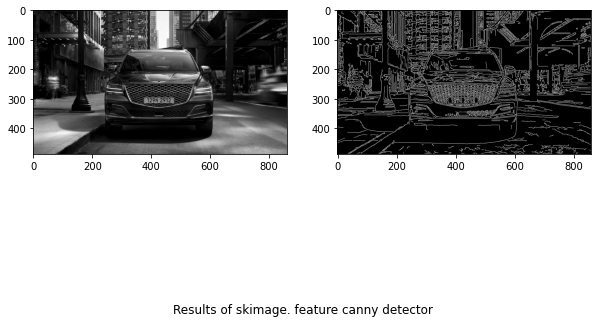

In [62]:
from skimage import feature

edges = feature.canny(originalImage)

fig, axs = plt.subplots(1,2, figsize=(10, 6.5))
axs[0].imshow(originalImage, cmap='gray')
axs[1].imshow(edges, cmap='gray')
txt='Results of skimage. feature canny detector'
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()